# House Prices: Advanced Regression Techniques - Part VI

In this notebook we will perform HPO one final time. 

In [2]:
from load_modules_files_functions_clean import *

No. features: 79
No. numerical features: 33
No. ordinal features: 21
No. (possible) categorical features: 25 

num_cols: ['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'LotFrontage'] 

ord_cols: ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond', 'Utilities', 'Functional', 'GarageFinish', 'PavedDrive', 'Alley', 'Fence', 'FireplaceQu', 'PoolQC'] 

cat_cols: ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condit

In [3]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,3,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,3,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,3,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,3,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,3,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


Define functions that have been problematic or that have to be redefined. 

In [4]:
def get_train_val_sets(X, y, cols, test_size = 0.20):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = test_size, random_state = 1)
    return X_train[cols], X_val[cols], y_train, y_val

def print_cv_val_score(my_s, print_best_est = True, adj_refit = False): # This function does not work properly when it is imported from load_modules_files_functions_clean; X[cols] is not updated correctly.   
    best_est = my_s.best_estimator_
    best_est.fit(X_train, y_train)       
    if adj_refit:
        best_idx = my_s.best_index_
        best_adj_CV_score = my_s.cv_results_['mean_test_score'][best_idx] - my_s.cv_results_['std_test_score'][best_idx]
        print('Best adjusted CV score:', round(-best_adj_CV_score, 5))
    else:
        best_CV_score = my_s.best_score_        
        print('Best CV score:', round(-best_CV_score, 5))
    if y_val.shape[0] > 0:
        y_pred = best_est.predict(X_val)
        val_score = rmsle(y_val, y_pred)
        print('Validation score:', round(val_score, 5))
    if print_best_est:
        print(best_est)
        
def get_sub_csv(my_s, cols, name_csv): # There is a similar problem for this function as well.
    print(name_csv)
    best_est = my_s.best_estimator_    
    best_est.fit(X[cols], y)
    X_test = test[cols]
    y_pred = best_est.predict(X_test)    
    test_submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':y_pred})
    test_submission.to_csv(name_csv, index=False)

def adj_refit_fn(cv_results):
    best_score_idx = np.argmax(cv_results['mean_test_score'] - cv_results['std_test_score'])    
    return(best_score_idx)

def load_run_save_GSCV(key, param_grid, save_s = True, adj_refit = False, cv = 5, save_results = False):
    if save_results:
        global results
    best_CV_score = np.nan
    val_score= np.nan
    filename = key + '.joblib'
    if os.path.isfile(filename):
        my_s = joblib.load(filename)
    else:
        if adj_refit:
            my_refit = adj_refit_fn
        else:
            my_refit = True
        my_s = GridSearchCV(ttr, param_grid = param_grid, cv = cv, scoring = rmsle_scorer, n_jobs = -1, verbose = 10, error_score = 'raise', refit = my_refit)
        my_s = my_s.fit(X_train, y_train)
        if save_s:
            joblib.dump(my_s, filename)
    best_est = my_s.best_estimator_
    best_est.fit(X_train, y_train)   
    
    if y_val.shape[0] > 0:
        y_pred = best_est.predict(X_val)
        val_score = rmsle(y_val, y_pred)
    if adj_refit:
        best_idx = my_s.best_index_
        best_adj_CV_score = my_s.cv_results_['mean_test_score'][best_idx] - my_s.cv_results_['std_test_score'][best_idx]
        print('Best adjusted CV score:', round(-best_adj_CV_score, 5))
    else:
        best_CV_score = my_s.best_score_        
        print('Best CV score:', round(-best_CV_score, 5))
    if y_val.shape[0] > 0:
        print('Validation score:', round(val_score, 5))      
    
    if save_results:
        results_model = pd.Series({'Best CV score': -best_CV_score, 'Val score':val_score})
        results_model.name = key
        results = results.append(results_model)
    return my_s

def min_imp_filter(cols, feat_imps, min_imp):
    feats_keep = list(feat_imps[feat_imps > min_imp].index)
    cols_keep = []
    for col in cols:
        if col in feats_keep:
            cols_keep.append(col)
    return cols_keep

Recreate the best peforming model obtained after HPO.

In [5]:
X['LowQualFinSFBinary'] = 0
X.loc[X['LowQualFinSF'] > 0, 'LowQualFinSFBinary'] = 1

test['LowQualFinSFBinary'] = 0
test.loc[test['LowQualFinSF'] > 0, 'LowQualFinSFBinary'] = 1

num_cols[num_cols.index('LowQualFinSF')] = 'LowQualFinSFBinary'

In [6]:
X_train, X_val, y_train, y_val = get_train_val_sets(X, y, num_cols + ord_cols + cat_cols)
X_train, X_val, y_train, y_val = pd.concat([X_train, X_val], axis = 0), pd.DataFrame(), pd.concat([y_train, y_val]), pd.DataFrame()

In [7]:
imputer = ColumnTransformer([
    ('imputer_num_cols', 'passthrough', slice(0, len(num_cols))),
    ('imputer_ord_cols', 'passthrough', slice(len(num_cols), len(num_cols + ord_cols))),
    ('imputer_cat_cols', 'passthrough' , slice(len(num_cols + ord_cols), len(num_cols + ord_cols + cat_cols))) 
])

preprocessor = ColumnTransformer([
            ('scaler_num_cols', 'passthrough', slice(0, len(num_cols))),
            ('scaler_ord_cols', 'passthrough', slice(len(num_cols), len(num_cols + ord_cols))),
            ('category_encoder_cat_cols', OneHotEncoder(handle_unknown = 'ignore'), slice(len(num_cols + ord_cols), len(num_cols + ord_cols + cat_cols)))
]) 

steps = [
    ('imputer', imputer),
    ('preprocessor', preprocessor),         
    ('model', None)
]

pipeline = Pipeline(steps)

ttr = TransformedTargetRegressor(regressor = pipeline, func = np.log1p, inverse_func = np.expm1)

gbr = GradientBoostingRegressor(random_state = 1)

param_grid = {
    'regressor__imputer__imputer_num_cols': [SimpleImputer(fill_value = -999)],
    'regressor__imputer__imputer_num_cols__strategy': ['mean', 'median', 'most_frequent', 'constant'],    
    'regressor__imputer__imputer_ord_cols': [SimpleImputer(fill_value = -999)],
    'regressor__imputer__imputer_ord_cols__strategy': ['mean', 'median', 'most_frequent', 'constant'],    
    'regressor__imputer__imputer_cat_cols': [SimpleImputer(fill_value = 'MISS')],
    'regressor__imputer__imputer_cat_cols__strategy': ['most_frequent', 'constant'],    
    'regressor__model': [gbr],
}

key = 'gbr_default_cat'

In [8]:
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False, cv = 5)
my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False, cv = 8)

Fitting 8 folds for each of 32 candidates, totalling 256 fits
Best CV score: 0.1228


<AxesSubplot:>

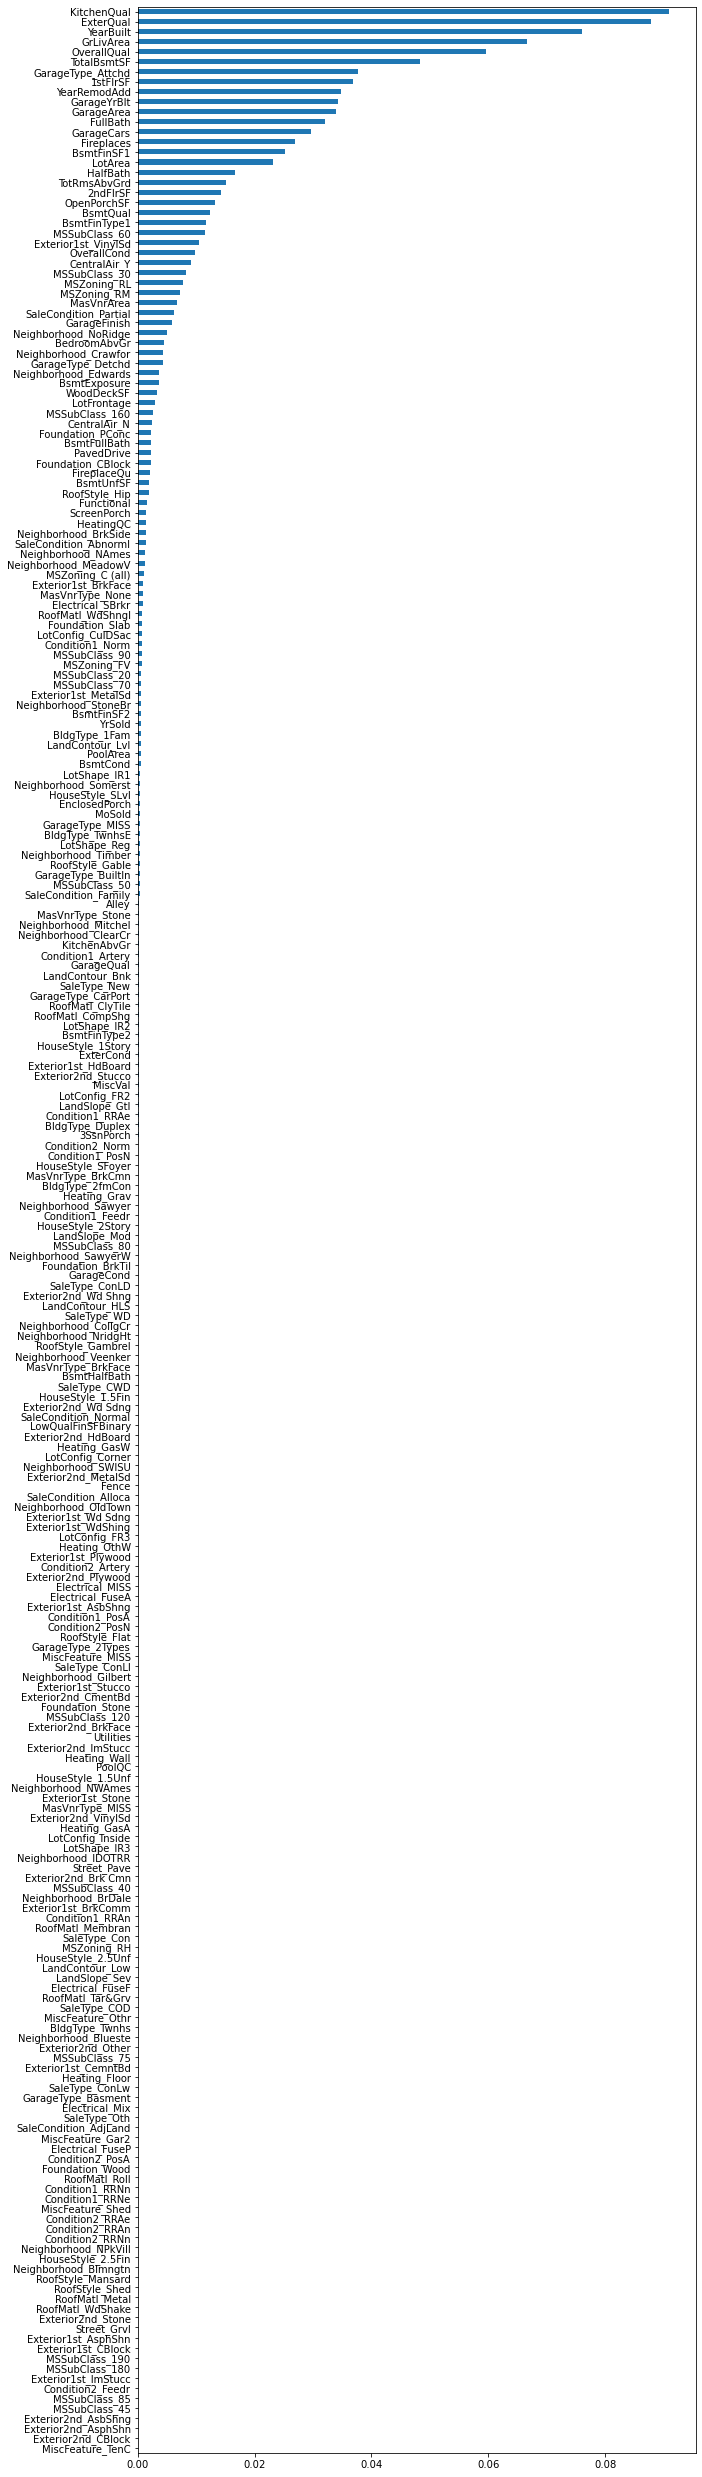

In [21]:
ohe = my_s.best_estimator_.regressor_.named_steps.preprocessor.named_transformers_.category_encoder_cat_cols
model = my_s.best_estimator_.regressor_.named_steps.model
feat_imps = pd.Series(model.feature_importances_, index = list(X[num_cols + ord_cols].columns) + \
                      list(ohe.get_feature_names(cat_cols)))
plt.figure(figsize = (10, 45))
feat_imps.sort_values(ascending = True).plot(kind='barh', rot = 0)

In [10]:
print('No. features after OHE:', len(model.feature_importances_))
print('No. features after OHE larger than 0:', len(model.feature_importances_[model.feature_importances_ > 0]))

No. features after OHE: 244
No. features after OHE larger than 0: 116


In [11]:
my_imputer = my_s.best_estimator_.regressor_.named_steps.imputer.named_transformers_

In [12]:
param_grid = {
    'regressor__imputer__imputer_num_cols': [SimpleImputer(fill_value = -999)],
    'regressor__imputer__imputer_num_cols__strategy': [my_imputer.imputer_num_cols.strategy],
    'regressor__imputer__imputer_ord_cols': [SimpleImputer(fill_value = -999)],
    'regressor__imputer__imputer_ord_cols__strategy': [my_imputer.imputer_ord_cols.strategy],
    'regressor__imputer__imputer_cat_cols': [SimpleImputer(fill_value = 'MISS')],
    'regressor__imputer__imputer_cat_cols__strategy': [my_imputer.imputer_cat_cols.strategy],
    'regressor__model': [gbr],    
    'regressor__model__loss': ['ls', 'lad', 'huber', 'quantile'], # default = 'ls' 
    'regressor__model__learning_rate': [0.01, 0.02, 0.05, 0.1, 1], # default =  0.1
    'regressor__model__n_estimators': [100, 200, 300, 400, 500], # default =  100
    'regressor__model__max_depth': [1, 2, 3, 4, 5, 6], # default = 3
    'regressor__model__max_features': [None, 'sqrt'], # default = None
    'regressor__model__min_samples_leaf': [1, 3, 5], # default = 1
    'regressor__model__min_samples_split': [2, 4, 8], # default = 2
    'regressor__model__ccp_alpha': [0, 0.1, 1, 10] # default = 0.0
}

# param_grid obtained after HPO on personal computer.
param_grid = {
    'regressor__imputer__imputer_num_cols': [SimpleImputer(fill_value = -999)],
    'regressor__imputer__imputer_num_cols__strategy': [my_imputer.imputer_num_cols.strategy],
    'regressor__imputer__imputer_ord_cols': [SimpleImputer(fill_value = -999)],
    'regressor__imputer__imputer_ord_cols__strategy': [my_imputer.imputer_ord_cols.strategy],
    'regressor__imputer__imputer_cat_cols': [SimpleImputer(fill_value = 'MISS')],
    'regressor__imputer__imputer_cat_cols__strategy': [my_imputer.imputer_cat_cols.strategy],
    'regressor__model': [gbr],    
    'regressor__model__loss': ['huber'],
    'regressor__model__learning_rate': [0.05],
    'regressor__model__n_estimators': [500],
    'regressor__model__max_depth': [3],
    'regressor__model__max_features': ['sqrt'],
    'regressor__model__min_samples_leaf': [1],
    'regressor__model__min_samples_split': [8],
    'regressor__model__ccp_alpha': [0],
}

key = 'gbr_HPO_cat'

In [13]:
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False, cv = 5)
my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False, cv = 8)

Fitting 8 folds for each of 1 candidates, totalling 8 fits
Best CV score: 0.12186


Perform a new HPO (with modified param_grid)

In [14]:
param_grid = {
    'regressor__imputer__imputer_num_cols': [SimpleImputer(fill_value = -999)],
    'regressor__imputer__imputer_num_cols__strategy': [my_imputer.imputer_num_cols.strategy],
    'regressor__imputer__imputer_ord_cols': [SimpleImputer(fill_value = -999)],
    'regressor__imputer__imputer_ord_cols__strategy': [my_imputer.imputer_ord_cols.strategy],
    'regressor__imputer__imputer_cat_cols': [SimpleImputer(fill_value = 'MISS')],
    'regressor__imputer__imputer_cat_cols__strategy': [my_imputer.imputer_cat_cols.strategy],
    'regressor__model': [gbr],    
    'regressor__model__loss': ['ls', 'lad', 'huber', 'quantile'], # default = 'ls' 
    'regressor__model__learning_rate': [0.01, 0.02, 0.05, 0.1], # default =  0.1
    'regressor__model__n_estimators': [100, 500, 750, 1000], # default =  100
    'regressor__model__max_depth': [1, 2, 3, 4, 5, 6], # default = 3
    'regressor__model__max_features': [None, 'sqrt'], # default = None
    'regressor__model__min_samples_leaf': [1, 3, 5], # default = 1
    'regressor__model__min_samples_split': [2, 4, 8], # default = 2
    #'regressor__model__ccp_alpha': [0, 0.1, 1, 10] # default = 0.0 ---> 0 was chosen anyway previously so probably no idea to include this regularization parameter.
    'regressor__model__subsample': [0.7, 0.8, 0.9, 1.0] # default = 1 ---> Added this parameter.
}

# param_grid obtained after HPO on personal computer.
param_grid = {
    'regressor__imputer__imputer_num_cols': [SimpleImputer(fill_value=-999)],
    'regressor__imputer__imputer_num_cols__strategy': [my_imputer.imputer_num_cols.strategy],
    'regressor__imputer__imputer_ord_cols': [SimpleImputer(fill_value=-999)],
    'regressor__imputer__imputer_ord_cols__strategy': [my_imputer.imputer_ord_cols.strategy],
    'regressor__imputer__imputer_cat_cols': [SimpleImputer(fill_value='MISS')],
    'regressor__imputer__imputer_cat_cols__strategy': [my_imputer.imputer_cat_cols.strategy],
    'regressor__model': [gbr],
    'regressor__model__loss': ['ls'],
    'regressor__model__learning_rate': [0.02],
    'regressor__model__n_estimators': [1000],
    'regressor__model__max_depth': [4],
    'regressor__model__max_features': ['sqrt'],
    'regressor__model__min_samples_leaf': [1],
    'regressor__model__min_samples_split': [2],
    'regressor__model__subsample': [0.8]}

Best CV score: 0.1161

In [15]:
my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False, cv = 8)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.5s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.5s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    4.8s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    4.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    4.9s finished


Best CV score: 0.11631


In [17]:
my_s.best_params_

{'regressor__imputer__imputer_cat_cols': SimpleImputer(fill_value='MISS', strategy='constant'),
 'regressor__imputer__imputer_cat_cols__strategy': 'constant',
 'regressor__imputer__imputer_num_cols': SimpleImputer(fill_value=-999, strategy='constant'),
 'regressor__imputer__imputer_num_cols__strategy': 'constant',
 'regressor__imputer__imputer_ord_cols': SimpleImputer(fill_value=-999, strategy='median'),
 'regressor__imputer__imputer_ord_cols__strategy': 'median',
 'regressor__model': GradientBoostingRegressor(ccp_alpha=0, learning_rate=0.02, max_depth=4,
                           max_features='sqrt', n_estimators=1000,
                           random_state=1, subsample=0.8),
 'regressor__model__learning_rate': 0.02,
 'regressor__model__loss': 'ls',
 'regressor__model__max_depth': 4,
 'regressor__model__max_features': 'sqrt',
 'regressor__model__min_samples_leaf': 1,
 'regressor__model__min_samples_split': 2,
 'regressor__model__n_estimators': 1000,
 'regressor__model__subsample': 0

In [16]:
name = 'gbr_sub_num_ord_cat_HPO.csv'
get_sub_csv(my_s, num_cols + ord_cols + cat_cols, name)

gbr_sub_num_ord_cat_HPO.csv


## Log

Best model so far (with HPO, 80% train, 20% val and cv = 5) ---> General pipeline -> CV: 0.12817, Val: 0.12800, After HPO of GBR -> CV: 0.12016, Val: 0.11978, Test: 0.12588

Best model so far (with HPO, 100% train, 0% val and cv = 8) ---> General pipeline -> CV: 0.12311, After HPO of GBR -> CV: 0.12134, Test: 0.12741
**Note:** The test score is worse, but that might be expected.

Best model so far (with HPO, 100% train, 0% val, cv = 8 and "small" FE ) ---> General pipeline -> CV: 0.12280, After HPO of GBR -> CV: 0.12186, Test: 0.12603

2nd HPO with modified param_grid ---> CV: 0.11631, Test: 0.12458 (better)
**Note:** Not an enormous improvement considering the fact that the HPO took four days to complete.